# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Цель исследования** - на основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей и сформулировать общие выводы/рекомендации.

**Ход исследования**

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц, в виде файла `gym_churn.csv`. Необходимо провести обзор и предобработку данных - обработать возможные дубликаты и пропуски, при необходимости поменять тип данных и создать дополнительные столбцы. Затем будет проведён общий исследовательский анализ, в ходе которого данные будут разделены на группы по наличию факта оттока, после чего на них будут изучены статистические параметры и их корреляция. На основе этих данных будут построены модели прогнозирования оттока клиентов и разделения клиентов на сегменты (кластеризация). После валидации этих моделей будет сформирован общий вывод.
Таким образом исследование будет разделено на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
2. [**Исследовательский анализ данных**](#2)
3. [**Прогнозирование оттока клиентов**](#3)
4. [**Кластеризация клиентов**](#4)
5. [**Общий вывод**](#5)

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
- `Churn` — факт оттока в текущем месяце.



<a id='1'></a>
## Обзор и предобработка данных

In [1]:
# импортируем библиотеки для работы с данными

import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# импортируем модули для машинного обучения

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

# настройки отображения

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
sns.set_style('darkgrid')
plt.rcParams.update({'axes.labelsize': 10,'axes.titlesize': 15})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

In [2]:
# загружаем данные, выводим общую информацию и пять случайных строк

data = pd.read_csv('gym_churn.csv')

data.info()
data.sample(5, random_state=0).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,2230,668,3616,2363,142
gender,0.00,0.00,0.00,1.00,1.00
Near_Location,1.00,0.00,0.00,1.00,0.00
Partner,1.00,0.00,1.00,0.00,1.00
Promo_friends,1.00,0.00,0.00,0.00,0.00
Phone,1.00,1.00,1.00,1.00,0.00
Contract_period,12.00,1.00,6.00,1.00,12.00
Group_visits,1.00,1.00,0.00,1.00,0.00
Age,29.00,27.00,30.00,27.00,29.00
Avg_additional_charges_total,260.51,48.09,24.62,139.89,89.66
Month_to_end_contract,12.00,1.00,5.00,1.00,12.00


- Данные содержат 14 столбцов и 4,000 записей. Явных пропусков не обнаружено.

Для удобства работы с таблицей приведём названия колонок приведём их к нижнему регистру: после чего выведем описательную статистику:

In [3]:
# меняем названия колонок

data.columns = data.columns.str.lower()

# описательная статистика

data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


- Большая часть данных имеет бинарный вид (представлены значениями `0` или `1`).


- Доля оттока клиентов в данных составляет 27%.


<a id='2'></a>
## Исследовательский анализ данных

Сначала посмотрим на распределение значений бинарных данных - если среднее значение столбца равно 0.5, значит в данных представлено равное количество посетителей в разрезе этого параметра:

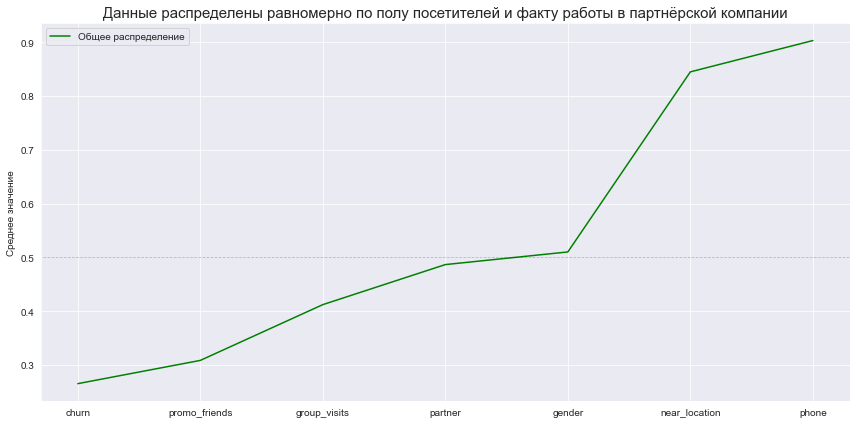

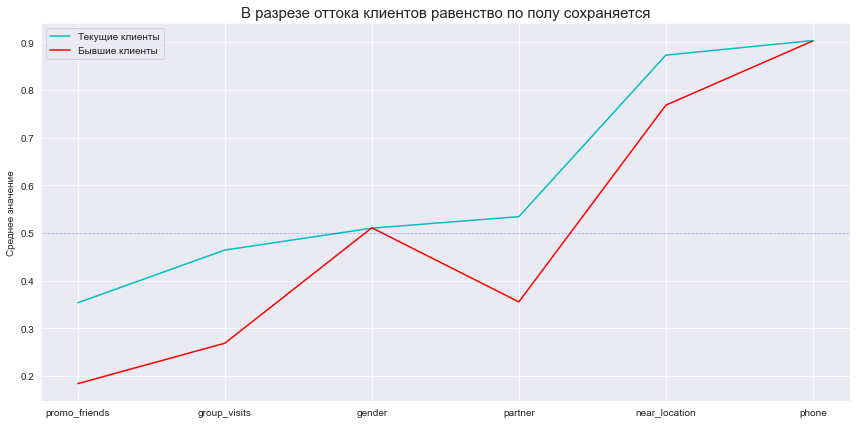

In [4]:
# формируем таблицы средних значений "бинарных данных"

def binary_pars(query=('churn == 0 or churn == 1')):

    binary_par = (
        data.query(query)
        .mean()
        .where(data.max()==1)
        .dropna()
        .sort_values()
    )
    return binary_par

# визуализируем общее распределение

plt.figure(figsize=(12,6))

sns.lineplot(data=binary_pars(), label='Общее распределение', color='g')

plt.axhline(y=.5, linewidth=0.5, color='b', linestyle=':')

plt.title("Данные распределены равномерно по полу посетителей и факту работы в партнёрской компании")
plt.ylabel("Среднее значение")

plt.tight_layout()
plt.show()


# визуализируем распределение в разрезе оттока клиентов

plt.figure(figsize=(12,6))


sns.lineplot(data=binary_pars('churn == 0').drop('churn'), 
             label='Текущие клиенты', color='c')

sns.lineplot(data=binary_pars('churn == 1').drop('churn'), 
             label='Бывшие клиенты', color='r')


plt.axhline(y=.5, linewidth=0.5, color='b', linestyle=':')

plt.title("В разрезе оттока клиентов равенство по полу сохраняется")
plt.ylabel("Среднее значение")

plt.tight_layout()
plt.show()

- В данных представлено равное количество посетителей в разрезе их пола и факта работы в компании-партнёре фитнес-центра


- Около 90% посетителей проживают или работают в районе, где находится фитнес-центр, а также предоставили контактный телефон


- Бывших посетителей центра (параметр `churn`) - меньше 20%


- Среди бывших посетителей значительно меньше посетителей групповых программ, сотрудников компаний-партнёров и тех, кого пригласили друзья.

Посмотрим на распределение каждого из остальных параметров:

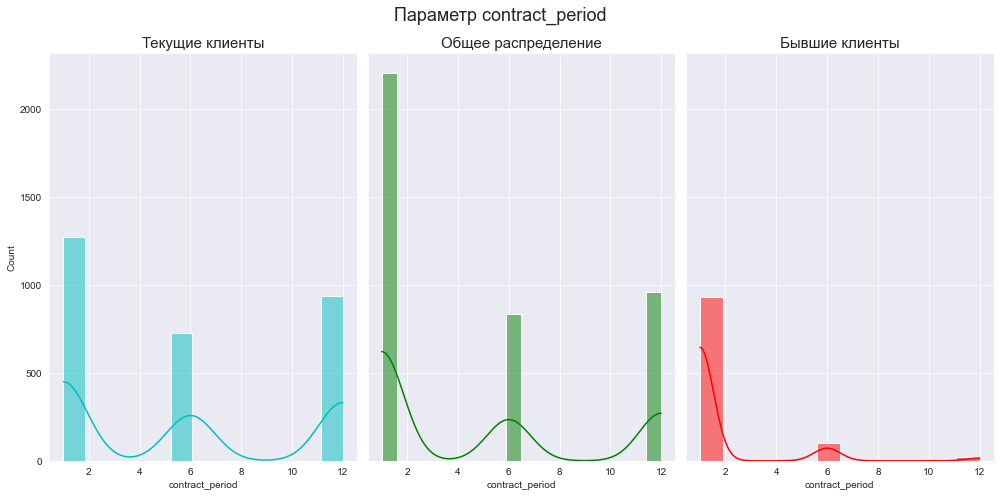

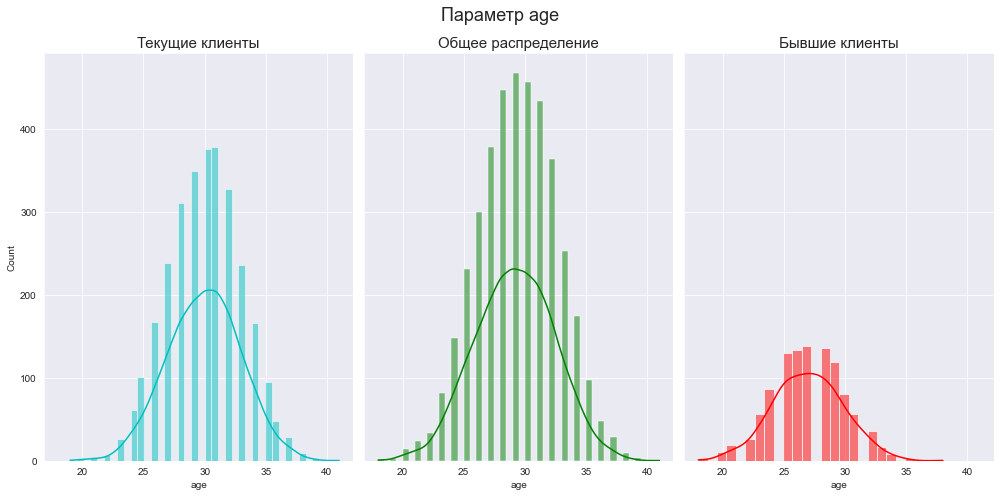

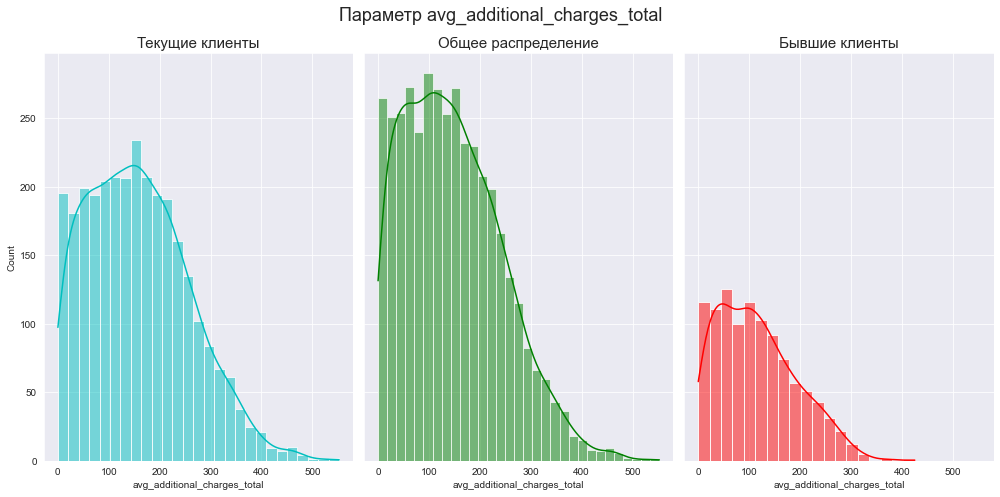

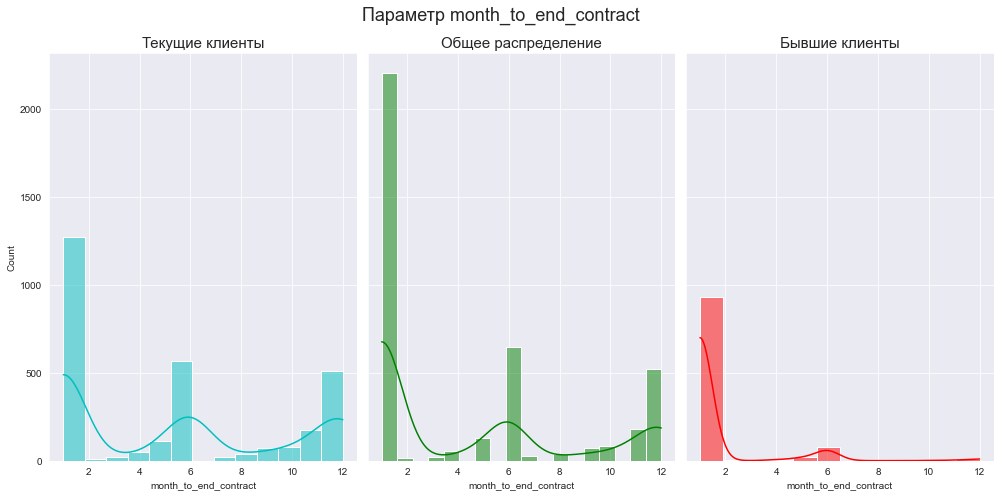

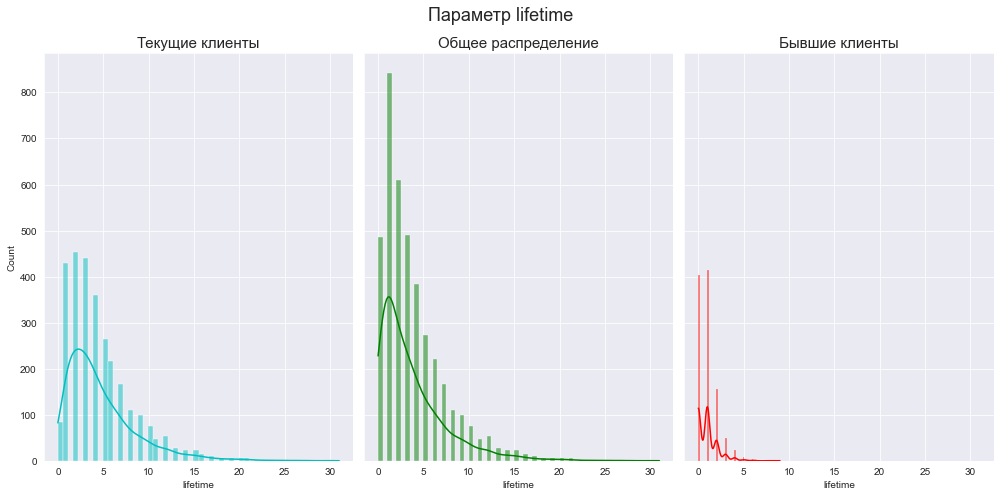

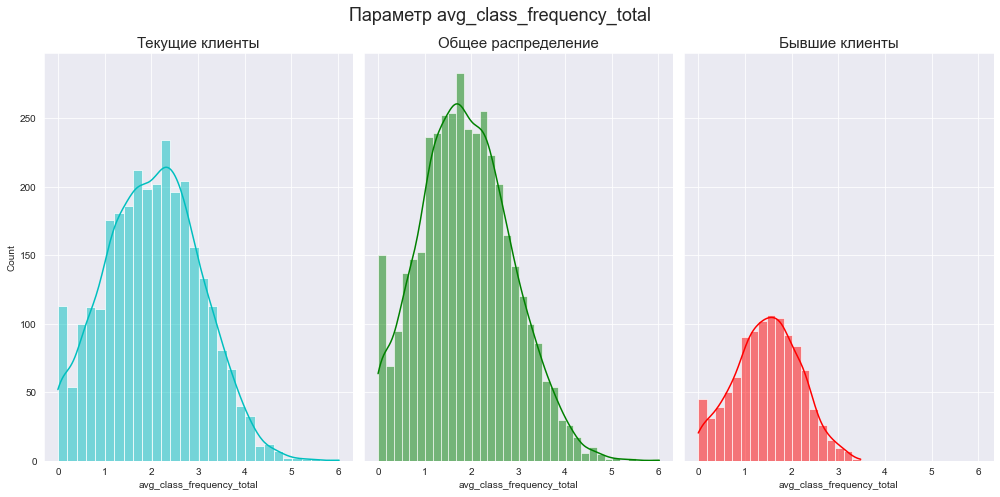

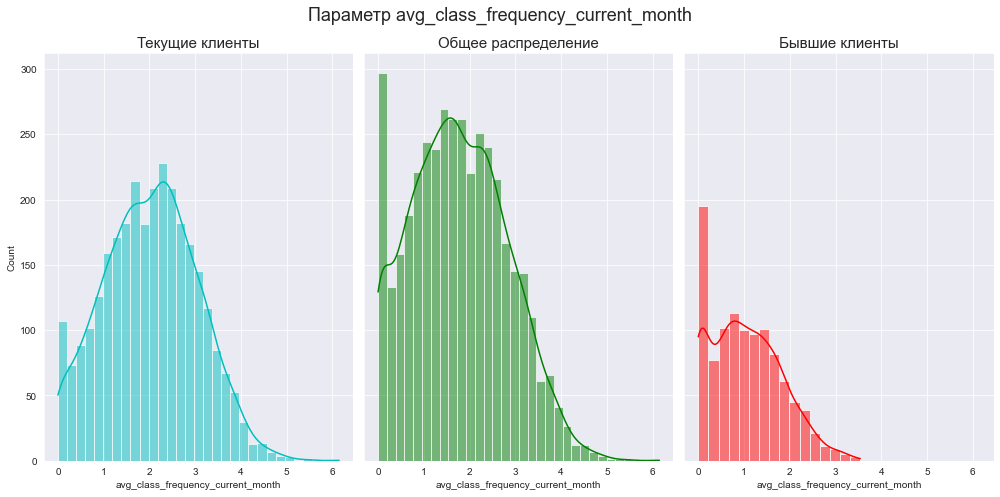

In [5]:
# сделаем список небинарных параметров

cols = [x for x in data.columns if x not in binary_pars().index.to_list()]


# визуализируем распределение

for val in cols:

    fig, (ax1, ax2, ax3) = (
        plt.subplots(1, 3, figsize=(14, 7),
                     sharey=True, sharex=True)
    )
    
    sns.histplot(data=data.query('churn == 0'), 
                 x=val, color='c', kde=True, ax=ax1)
    
    sns.histplot(data=data, 
                 x=val, color='g', kde=True, ax=ax2)
    
    sns.histplot(data=data.query('churn == 1'), 
                 x=val, color='r', kde=True, ax=ax3)
    
    fig.suptitle("Параметр " + val, fontsize=18)
    ax1.set_title('Текущие клиенты')
    ax2.set_title('Общее распределение')
    ax3.set_title('Бывшие клиенты')
    plt.tight_layout()
    plt.show()

- Текущие клиенты задают тренд для общего распределения всех небинарных параметров


- Фитнесс-центр предлагает три вида контракта - на 1 месяц, полгода и год. Месячный контракт является самым популярным, у бывших клиентов он преобладает больше всего. Практически у всех бывших клиентов был 1 месяц до окончания контракта на момент оттока.


- Возраст клиентов имеет идеальный вид нормального распределения


- Распределение параметра средней суммы дополнительных трат имеет смещение влево - значительная часть клиентов не пользовалась доп.услугами центра


- У бывших клиентов значительно меньший показатель `lifetime`.


- Бывшие клиенты значительно реже посещали центр, большая часть не имеет ни одного визита в последнем месяце.

Теперь визуализируем корреляцию параметров между собой:

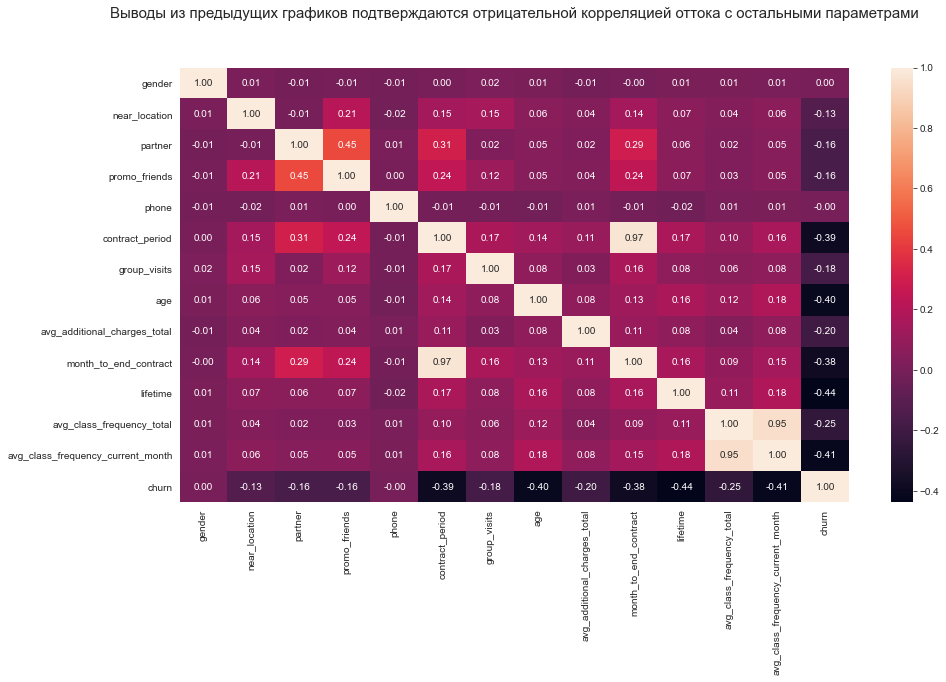

In [6]:
# построим тепловую карту корреляции параметров

plt.figure(figsize=(15,8))

sns.heatmap(data.corr(), annot=True, fmt='.2f')

plt.title(
    'Выводы из предыдущих графиков подтверждаются ' 
    'отрицательной корреляцией оттока с остальными параметрами'
    , y=1.1)

plt.show()

- Около половины параметров имеют умеренную отрицательную корреляцию с оттоком клиентов


- Высокий уровень корреляции можно наблюдать у только у двух пар параметров: длительность абонимента/срок его окончания, общее среднее количество посещений/среднее количество посещений за прошлый месяц.


- Пол клиента и наличие контактного телефона имеет нулевую корреляцию с любым другим параметром.

Поскольку мультиколлинеарность признаков может создать сложности в прогнозировании, будет целесообразнее избавиться от пар коррелирующих параметров:

In [7]:
# удалим данные об общем среднем количестве посещений и сроку окончания контракта 
# убираем из датасета и списка небинарных параметров

cols_to_drop = ['avg_class_frequency_total', 'month_to_end_contract']

data.drop(columns= cols_to_drop, inplace=True)
cols.remove(cols_to_drop[0])
cols.remove(cols_to_drop[1])

<a id='3'></a>
## Прогнозирование оттока клиентов

Поскольку целевое значения для прогноза (параметр `churn`) является бинарной переменной, прогнозирование можно представить в виде задачи по бинарной классификации, реализуемой с помощью алгоритмов машинного обучения.

In [8]:
# разделим данные на признаки и целевую переменную

x = data.drop('churn', axis=1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state=0, stratify=y
)

# стандартизируем данные

scaler = StandardScaler()
scaler.fit(x_train)

x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

# функция для обучения модели

def prediction(model, title):

    model = model
    model.fit(x_train_st, y_train)

    probabilities = model.predict_proba(x_test_st)[:, 1]
    predictions = model.predict(x_test_st)
    
    print(title)
    print()
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))
    print()

Для повышения точности прогноза используем два разных алгоритма обучения - логистическую регрессию и ансабль "случайного леса":

In [9]:
# модель логистической регрессии

prediction(LogisticRegression(solver='liblinear'), "Метрики логистической регрессии")

# модель случайного леса

prediction(RandomForestClassifier(n_estimators = 100, random_state=0), "Метрики случайного леса")

Метрики логистической регрессии

Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84
ROC_AUC: 0.97

Метрики случайного леса

Accuracy: 0.91
Precision: 0.85
Recall: 0.77
F1: 0.81
ROC_AUC: 0.96



- В целом обе модели сработили хорошо, но метрики алгоритма логистической регрессии показывают лучший результат.

<a id='4'></a>
## Кластеризация клиентов

Теперь попробуем выделить сегменты клиентов с помощью алгоритмов кластеризации. Для начала необходимо предположить оптимальное количество кластеров - для этого преобразуем данные с помощью алгоритма агломеративной кластеризации и визуализируем полученную матрицу признаков с помощью дендрограммы:

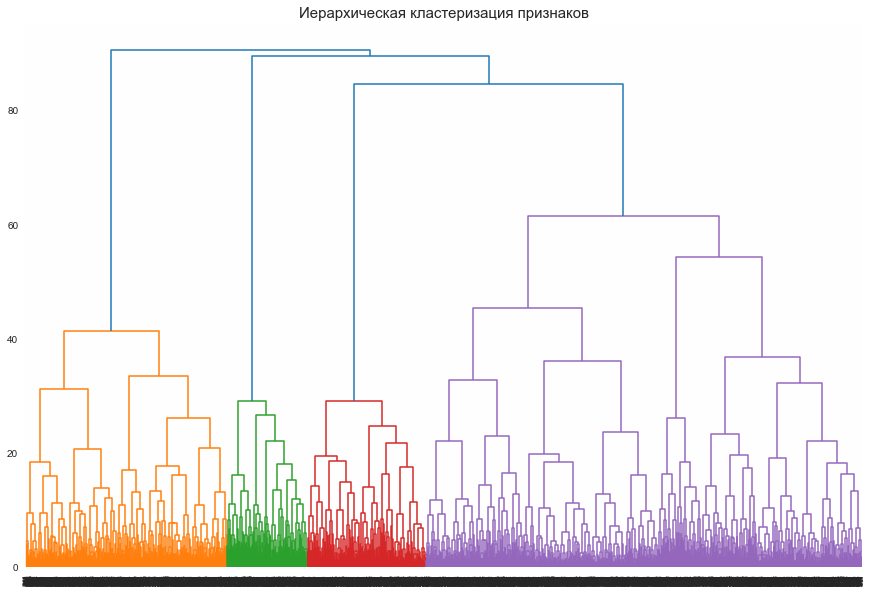

In [10]:
# стандартизируем и преобразовываем данные, предварительно убрав целевую переменную

data_sc = scaler.fit_transform(data.drop(columns='churn'))
linked = linkage(data_sc, method = 'ward')

# визуализируем результат

plt.figure(figsize=(15, 10)) 

dendrogram(linked, orientation='top')

plt.title('Иерархическая кластеризация признаков')
plt.show()

Алгоритм разделил данные на четыре кластера - используем полученную информацию для кластеризации с помощью алгоритма "K-Means":

In [11]:
# задаём 4 кластера для модели и обучаем на стандартизированных данных

km = KMeans(n_clusters=4, random_state=0)
clusters = km.fit_predict(data_sc)

# сохраняем метки кластера в поле нашего датасета

data['cluster'] = clusters

Теперь мы можем группировать данные по выделенным кластерам. Повторим обзор распределения данных для сгруппированных данных:

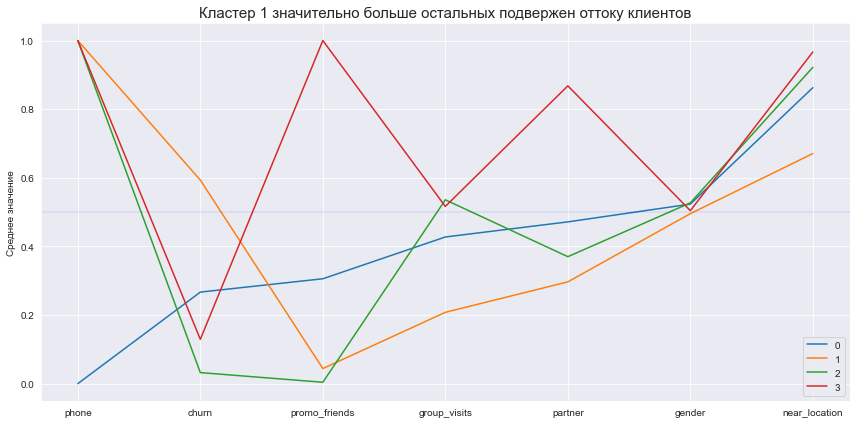

In [12]:
# визуализируем распределение среднего значения бинарных параметров

plt.figure(figsize=(12,6))

for i in range (0, 5):
    sns.lineplot(data=binary_pars('cluster == @i'), 
                 label=i)


plt.axhline(y=.5, linewidth=0.3, color='b', linestyle=':')

plt.title("Кластер 1 значительно больше остальных подвержен оттоку клиентов")
plt.ylabel("Среднее значение")

plt.tight_layout()
plt.show()

Краткая характеристика кластеров:

- Кластер `0` отличается отсутствием контактного телефона и оттоком на уровне 30%


- Кластер `1` больше всех подвержен оттоку клиентов (60%), характерен низким количеством клиентов по акции "Приведи друга" и самым низким количеством клиентов, работающих или живущих в районе фитнес-центра


- У кластера `2` самый низкий отток и количество клиентов "Приведи друга", но при этом же один из самых высоких показателей посещения групповых занятий. 


- Кластер `3` на 100% состоит из клиентов по акции "Приведи друга", характерен самым высоким уровнем клиентов-сотрудников партнёрских компаний.


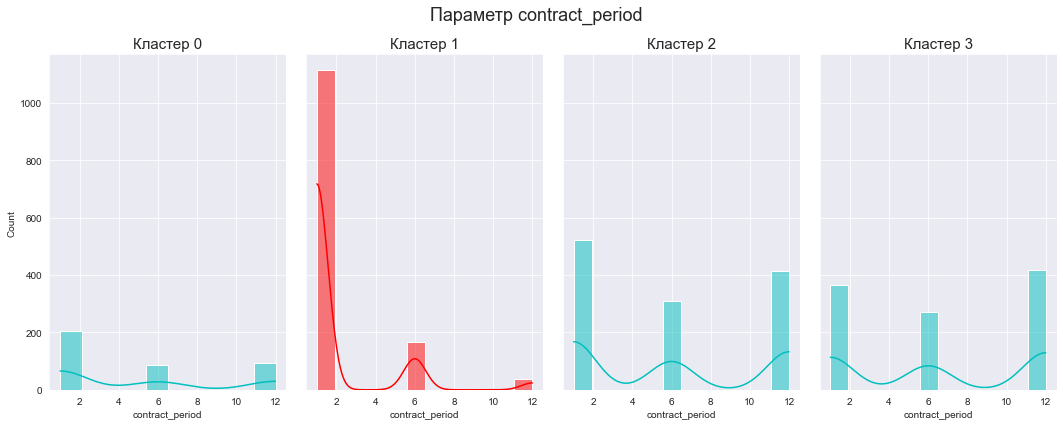

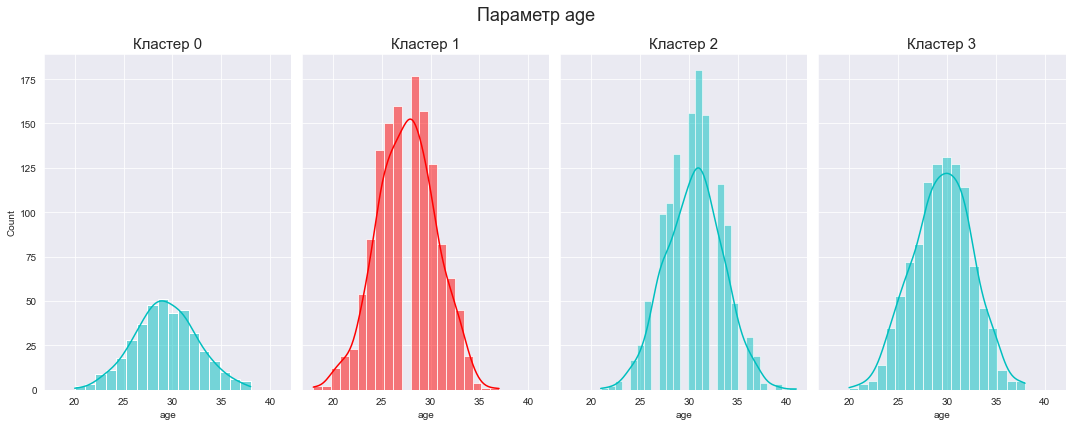

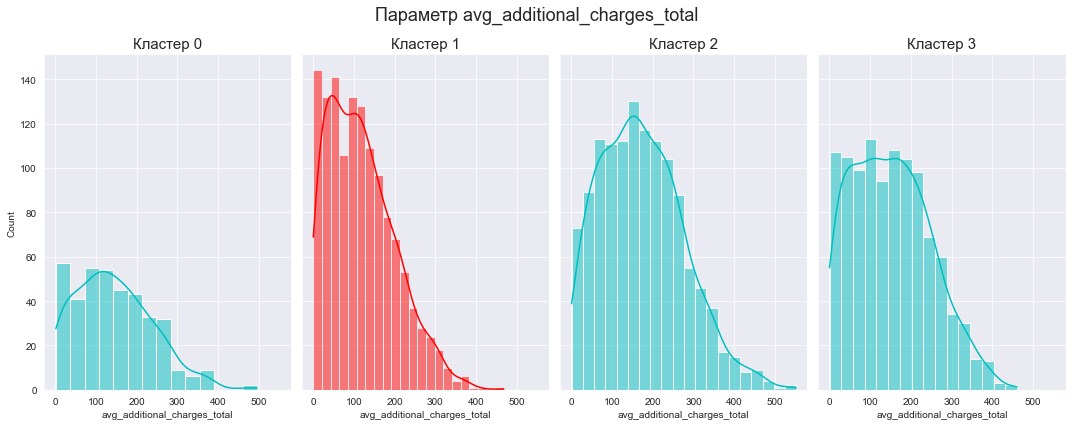

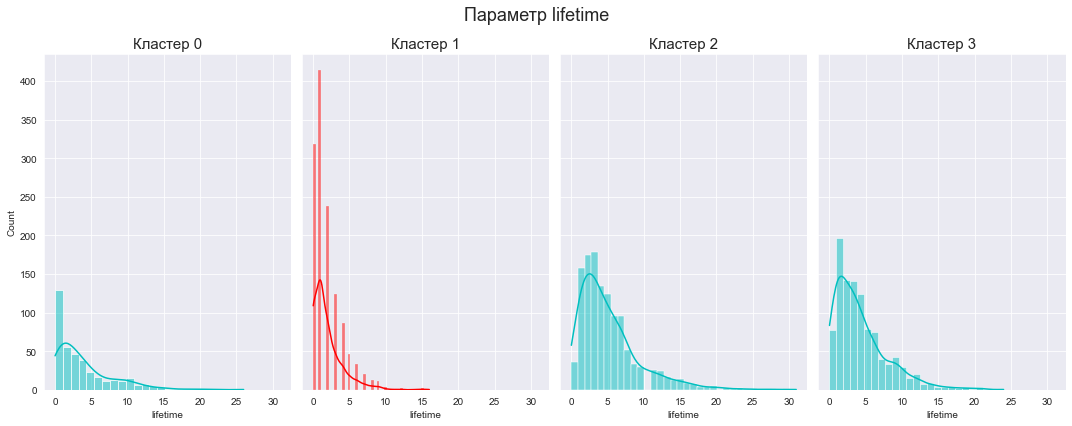

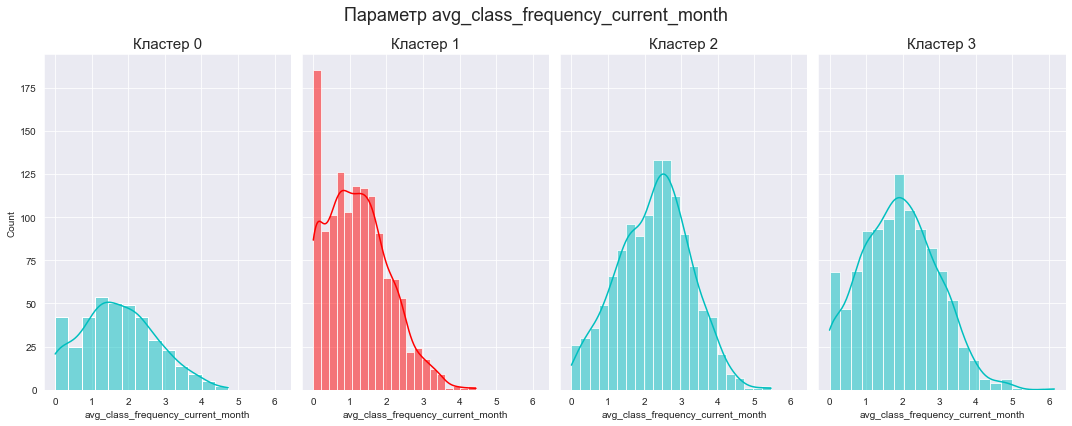

In [13]:
# визуализируем распределение небинарных параметров
# также выделим кластер с наибольшим оттоком клиентов

for val in cols:

    fig, axes = (
        plt.subplots(1, 4, figsize=(15, 6),
                     sharey=True, sharex=True)
    )
    
    for i in range(0, 4):    
        
        if i==1:
            color='r'
        else:
            color='c'
        
        sns.histplot(data=data.query('cluster == @i'), 
                     x=val, kde=True, ax=axes[i], color=color)
    
        fig.suptitle("Параметр " + val, fontsize=18)
        axes[i].set_title(label='Кластер ' + str(i))
  
    plt.tight_layout()
    plt.show()

- Для кластера `1`, являющегося наиболее подверженным оттоку клиентов, характерно явное преобладание клиентов с месячным контрактом, низким показателем `lifetime` и большим количеством клиентов с отсутствием посещений за последний месяц.

<a id='5'></a>
## Общий вывод

___
**Рекомендации**

- Возраст клиентов, пол и наличие контактного телефона не имеет значительного влияния на показатель оттока - эти параметры можно не учитывать в будущих анализах. Средняя сумма затрат на дополнительные услуги также не сигнализирует о факте оттока - во всех сегментах представлено большое количество клиентов, не пользующаяся этими услугами.

- Больше всего оттоку подвержены новые клиенты, приобретающие месячные контракты. Снижение среднего количество посещений за последний месяц до нуля также является показательным индикатором. Цикл жизни клиента, подверженному оттоку, редко превышает полгода и обычно составляет 1 месяц. Эти выводы указывают на целесообразность более активного продвижения полугодовых и годовых контрактов.

- При внедрении моделей машинного обучения в прогнозировании оттока клиентов самым оптимальным алгоритмом является логистическая регрессия.
____

Целью исследования являлось прогнозирование на основе данных о посетителях сети фитнес-центров вероятности оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей и сформулировать общие выводы/рекомендации.

**Ход исследования**

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц, в виде файла `gym_churn.csv`. Был проведён обзор и предобработка данных, а после - общий исследовательский анализ, в ходе которого данные были разделены на группы по наличию факта оттока, после чего на них были изучены статистические параметры и их корреляция. На основе этих данных была построена модель прогнозирования оттока клиентов и разделения клиентов на сегменты (кластеризация). 

Таким образом исследование было разделено на следующие этапы:

1. [**Обзор и предобработка данных**](#1)
2. [**Исследовательский анализ данных**](#2)
3. [**Прогнозирование оттока клиентов**](#3)
4. [**Кластеризация клиентов**](#4)
5. [**Общий вывод**](#5)

**В ходе предобработки и исследовательского анализа были сделаны следующие выводы:**

- Данные содержат 14 столбцов и 4,000 записей. Явных пропусков не обнаружено.


- Большая часть данных имеет бинарный вид (представлены значениями `0` или `1`).


- В данных представлено равное количество посетителей в разрезе их пола и факта работы в компании-партнёре фитнес-центра


- Около 90% посетителей проживают или работают в районе, где находится фитнес-центр, а также предоставили контактный телефон


- Бывших посетителей центра (параметр `churn`) - меньше 20%


- Среди бывших посетителей значительно меньше посетителей групповых программ, сотрудников компаний-партнёров и тех, кого пригласили друзья.

- Текущие клиенты задают тренд для общего распределения всех небинарных параметров


- Фитнесс-центр предлагает три вида контракта - на 1 месяц, полгода и год. Месячный контракт является самым популярным, у бывших клиентов он преобладает больше всего. Практически у всех бывших клиентов был 1 месяц до окончания контракта на момент оттока.


- Возраст клиентов имеет идеальный вид нормального распределения


- Распределение параметра средней суммы дополнительных трат имеет смещение влево - значительная часть клиентов не пользовалась доп.услугами центра


- У бывших клиентов значительно меньший показатель `lifetime`.


- Бывшие клиенты значительно реже посещали центр, большая часть не имеет ни одного визита в последнем месяце.

- Около половины параметров имеют умеренную отрицательную корреляцию с оттоком клиентов


- Высокий уровень корреляции можно наблюдать у только у двух пар параметров: длительность абонимента/срок его окончания, общее среднее количество посещений/среднее количество посещений за прошлый месяц.


- Пол клиента и наличие контактного телефона имеет нулевую корреляцию с любым другим параметром.

**При построении моделей прогнозирования и кластеризации были сделаны следующие выводы:**

- Метрики алгоритма логистической регрессии для обучения модели машинного обучения показывают намлучший результат для прогнозирования оттока клиентов.

Краткая характеристика кластеров:

- Кластер `0` отличается отсутствием контактного телефона и оттоком на уровне 30%


- Кластер `1` больше всех подвержен оттоку клиентов (60%), характерен низким количеством клиентов по акции "Приведи друга" и самым низким количеством клиентов, работающих или живущих в районе фитнес-центра. По небинарным параметрам также характерно явное преобладание клиентов с месячным контрактом, низким показателем `lifetime` и большим количеством клиентов с отсутствием посещений за последний месяц.


- У кластера `2` самый низкий отток и количество клиентов "Приведи друга", но при этом же один из самых высоких показателей посещения групповых занятий. 


- Кластер `3` на 100% состоит из клиентов по акции "Приведи друга", характерен самым высоким уровнем клиентов-сотрудников партнёрских компаний.
